In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Inicialización

El primer paso que vamos a realizar es cargar las dos tablas en dos data frames distintos. 

In [2]:
df_volvera = pd.read_csv("tp-2020-2c-train-cols1.csv")
df_volvera

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1
...,...,...
796,448,1
797,636,1
798,848,0
799,304,1


In [3]:
df_usuario = pd.read_csv("tp-2020-2c-train-cols2.csv")
df_usuario

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo
...,...,...,...,...,...,...,...,...,...,...,...
796,normal,Señor Bernardo Melesio,448,hombre,37.0,0,0,3359;6,3,NaN,fiumark_palermo
797,3d,Señorita Lidia Catalina,636,mujer,31.0,0,0,45988:,2,NaN,fiumark_palermo
798,4d,Señor Arturo Antenor,848,hombre,38.0,0,0,56;435,1,NaN,fiumark_chacarita
799,3d,Señorita Natividad Sofia,304,mujer,NaN,0,0,4487;5,2,adelante,fiumark_quilmes


En un primer análisis, podemos ver de ambas tablas que poseen un total de 801 filas. 

Consideramos hacer un join de las mismas, para operar y analizar la variable target(`volveria`) junto con los datos. 
Para ello utilizamos el campo `id_usuario` el cual es compartido.

Dejaremos en la variable `df_joined` las tablas unidas sin modificar, y usaremos `df` para ir realizando operaciones sobre la misma.

In [4]:
df_joined = df_usuario.join(df_volvera.set_index('id_usuario'), on='id_usuario', how='inner').set_index('id_usuario')
df = df_joined.copy()
df

,tipo_de_sala,nombre,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
id_usuario,,,,,,,,,,,
117,4d,Señor Camilo Pedro,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes,0
658,4d,Señora Raquel Angelica,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes,0
794,normal,Señor Antonio Federico,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita,0
455,4d,Señor Osvaldo Aureliano,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo,0
173,4d,Señorita Rita Eudosia,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo,1
...,...,...,...,...,...,...,...,...,...,...,...
448,normal,Señor Bernardo Melesio,hombre,37.0,0,0,3359;6,3,NaN,fiumark_palermo,1
636,3d,Señorita Lidia Catalina,mujer,31.0,0,0,45988:,2,NaN,fiumark_palermo,1
848,4d,Señor Arturo Antenor,hombre,38.0,0,0,56;435,1,NaN,fiumark_chacarita,0


# Análisis de Datos

## Columnas con información duplicada

En este paso vamos a tratar de averiguar si tenemos información duplicada. El siguiente comando nos mostrara si existen filas exactamente iguales en la encuesta.

In [5]:
df[df.duplicated(keep=False)]

,tipo_de_sala,nombre,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
id_usuario,,,,,,,,,,,


Lo bueno de la verifcación anterior es que sabemos que no existio multiples respuestas exactamente iguales.

## Columnas con ausencia de información

El objetivo de este análisis es poder entender cuales son las columnas que poseen faltante de información.

In [6]:
simbols = ["-","","_"]
for c in simbols:
    print("Column has simbol: '",c,"'")
    print(df.astype('str').eq(c).any())

Column has simbol: ' - '
tipo_de_sala     False
nombre           False
genero           False
edad             False
amigos           False
parientes        False
id_ticket        False
precio_ticket    False
fila             False
nombre_sede      False
volveria         False
dtype: bool
Column has simbol: '  '
tipo_de_sala     False
nombre           False
genero           False
edad             False
amigos           False
parientes        False
id_ticket        False
precio_ticket    False
fila             False
nombre_sede      False
volveria         False
dtype: bool
Column has simbol: ' _ '
tipo_de_sala     False
nombre           False
genero           False
edad             False
amigos           False
parientes        False
id_ticket        False
precio_ticket    False
fila             False
nombre_sede      False
volveria         False
dtype: bool


Viendo el resultado anterior, sabemos que no existen caracteres especiales que puedan representar la ausencia de valor distinto a NaN.

A continuación, analizaremos las tablas con valores númericos. En la columna `edad` deberemos considerar como inválido cualquier valor menor o igual a cero. mientras que las columnas numéricas `amigos` `parientes` `precio_ticket` `volveria`, un valor menor a cero sería invalido.

In [7]:
(df['edad'] <= 0).any()

False

In [8]:
columnas_con_numeros = ['amigos', 'parientes', 'precio_ticket', 'volveria']
(df[columnas_con_numeros] < 0).any()

amigos           False
parientes        False
precio_ticket    False
volveria         False
dtype: bool

Por lo visto de analizar la información, no tenemos casos extraños de respuestas que requieran de un análisis particular. Sin embargo, nos queda una verificacición de reelevancia como lo es verificar valores en `null`.

In [9]:
df.isnull().sum()

tipo_de_sala       0
nombre             0
genero             0
edad             160
amigos             0
parientes          0
id_ticket          0
precio_ticket      0
fila             624
nombre_sede        2
volveria           0
dtype: int64

Como podemos ver de este último comando, la columna `fila` posee unos 624 nulls de los 801 valores. Adicionalmente, la segunda columna con poca información es la columna edad. A continuación calcularemos el porcentaje de que ausencia de valor de dichas columnas.

In [10]:
(df.isnull().mean()*100).to_frame('porcentaje nulls')

,porcentaje nulls
tipo_de_sala,0.000000
nombre,0.000000
genero,0.000000
edad,19.975031
amigos,0.000000
parientes,0.000000
id_ticket,0.000000
precio_ticket,0.000000
fila,77.902622
nombre_sede,0.249688


Viendo estos valores, podemos observar que en la columna `fila` que representa la fila donde se sento el cliente al ver la pelicula tiene un 78% de ausencia de información. En cuanto a la columna `edad`, encontramos un 20% de faltante de información. 

Es importante mencionar tambien que la columna `nombre_sede` tiene algunos valores en null por lo que deberemos tomar una decisión de que hacer con dichas entradas. En este paso vamos consultar si tenemos alguna fila duplicada. El siguiente comando nos mostrara si existen respuestas exactamente iguales en la encuesta. **TODO: Mencionar que hicimos con las variables nulas de sede.**

## Funciones para el Analisis de cada Columna

La función `porcentajeVolveria` nos servira para poder obtener los porcentajes que volverian basados en un agrupamiento.

In [11]:
def porcentajeVolveria(group):
    return (group == 1).mean() * 100.0

## Análisis de la columna "nombre" y "numero_de_ticket"

Consideramos que el análisis de nombres y de los números de tickets son irrelevantes para determinar una relación que sirva a fiumark para determinar si la persona volveria ó no.

Analizar estas variables podría conducir a correlaciones espurias con la variable target.

## Analisis de la columna "Fila"

En este inciso analizaremos la columna `Fila`. Como vimos anteriormente, es una columna con muchos valores vacios. Es importante poder ver que hacer con dichos valores o si la columna tiene algo de información que nos pueda ser util. 

In [12]:
volveria_por_fila = df.groupby(by='fila').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_fila

,volveria
fila,
adelante,68.902439
medio,53.846154


Text(0.5, 1.0, 'Volverian segun la fila')

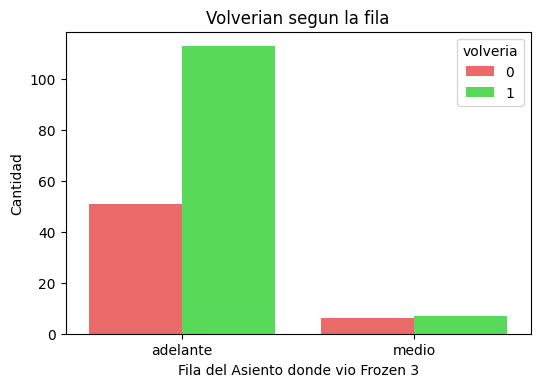

In [13]:
plt.figure(dpi=100)
sns.countplot(data=df, x='fila', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Fila del Asiento donde vio Frozen 3")
plt.title("Volverian segun la fila")

Además del gran cantidad de ausencia de información acerca de dicha variable, lo que vemos es que la gran mayoría que contesto dijo que lo hizo en filas de adelante, lo que en principio nos dificulta poder hacer una diferencia entre los dos valores que tenemos que nos pueda determinar concretamente una relación entre el lugar donde se sento y la preferencia para volver.

Teniendo esto en cuenta, y que no podemos inferir un valor para reemplazar en las ausencias, vamos a proceder a descartar dicha columna de nuestros analisis.

In [14]:
df.drop(columns=['fila'],inplace=True)
df

,tipo_de_sala,nombre,genero,edad,amigos,parientes,id_ticket,precio_ticket,nombre_sede,volveria
id_usuario,,,,,,,,,,
117,4d,Señor Camilo Pedro,hombre,73.5,0,0,59258;,1,fiumark_quilmes,0
658,4d,Señora Raquel Angelica,mujer,35.0,1,1,586:6;,2,fiumark_quilmes,0
794,normal,Señor Antonio Federico,hombre,NaN,0,0,"RE""39822",3,fiumark_chacarita,0
455,4d,Señor Osvaldo Aureliano,hombre,NaN,0,0,"C17""4:39",1,fiumark_palermo,0
173,4d,Señorita Rita Eudosia,mujer,4.0,1,1,569964,2,fiumark_palermo,1
...,...,...,...,...,...,...,...,...,...,...
448,normal,Señor Bernardo Melesio,hombre,37.0,0,0,3359;6,3,fiumark_palermo,1
636,3d,Señorita Lidia Catalina,mujer,31.0,0,0,45988:,2,fiumark_palermo,1
848,4d,Señor Arturo Antenor,hombre,38.0,0,0,56;435,1,fiumark_chacarita,0


## Analisis de la columna "Edad"

Reutilizaremos la función definida anteriomente para analizar la columna edad.

In [15]:
volveria_por_edad = df.groupby(by='edad').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_edad

,volveria
edad,
3.42,100.000000
3.67,100.000000
3.75,100.000000
3.83,100.000000
4.00,71.428571
...,...
73.00,0.000000
73.50,0.000000
74.00,0.000000


En un primer analisis sobre las edades, podemos observar valores decimales lo cual genera demasiados valores posibles para dicha variable. Para poder optimizar los calculos, vamos a generar una categoría agrupando de a 10 años tomando su digito mas significativo. Ejemplo, todos aquellos que respondieron que tienen entre 20 y 30 años, estaran categorizados como 2.

In [16]:
def categorizarEdad(edad):
    if(np.isnan(edad)):
        return edad
    else:
        return int(round(edad/10,0))


df['edad_categorizada'] = df.edad.apply(categorizarEdad)
df

,tipo_de_sala,nombre,genero,edad,amigos,parientes,id_ticket,precio_ticket,nombre_sede,volveria,edad_categorizada
id_usuario,,,,,,,,,,,
117,4d,Señor Camilo Pedro,hombre,73.5,0,0,59258;,1,fiumark_quilmes,0,7.0
658,4d,Señora Raquel Angelica,mujer,35.0,1,1,586:6;,2,fiumark_quilmes,0,4.0
794,normal,Señor Antonio Federico,hombre,NaN,0,0,"RE""39822",3,fiumark_chacarita,0,NaN
455,4d,Señor Osvaldo Aureliano,hombre,NaN,0,0,"C17""4:39",1,fiumark_palermo,0,NaN
173,4d,Señorita Rita Eudosia,mujer,4.0,1,1,569964,2,fiumark_palermo,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
448,normal,Señor Bernardo Melesio,hombre,37.0,0,0,3359;6,3,fiumark_palermo,1,4.0
636,3d,Señorita Lidia Catalina,mujer,31.0,0,0,45988:,2,fiumark_palermo,1,3.0
848,4d,Señor Arturo Antenor,hombre,38.0,0,0,56;435,1,fiumark_chacarita,0,4.0


Text(0.5, 1.0, 'Volverian segun categoria de edad')

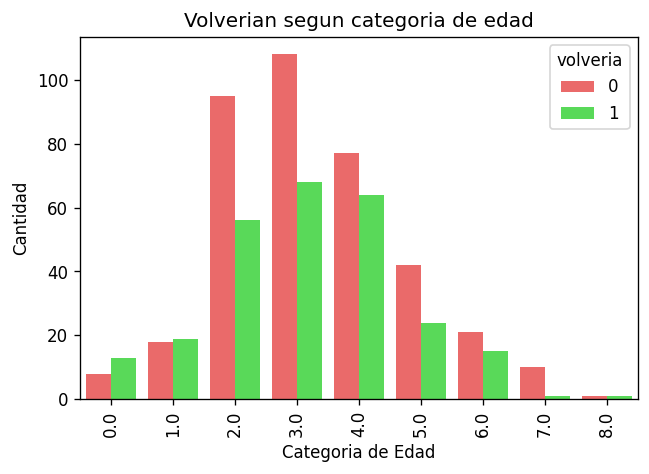

In [17]:
plt.figure(dpi=120)
sns.countplot(data=df, x='edad_categorizada', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xticks(rotation='vertical')
plt.xlabel("Categoria de Edad")
plt.title("Volverian segun categoria de edad")

El grafico anterior nos muestra que para personas con edad menor a 20 años, existe ciertos valores que podrian indicar una preferencia por volver. Sin embargo, de 20 años en adelante, en cada categoría la mayoria dice que no volveria. Esto tambien lo podemos observar obteniendo los porcentajes que volverian segun cada categoría.

In [18]:
df.groupby(by='edad_categorizada').agg({
        "volveria" : porcentajeVolveria
})

,volveria
edad_categorizada,
0.0,61.904762
1.0,51.351351
2.0,37.086093
3.0,38.636364
4.0,45.390071
5.0,36.363636
6.0,41.666667
7.0,9.090909
8.0,50.000000


## Analisis de la columna "Genero"

Para el analisis por genero, lo primero que trataremos de observa es si existe algun tipo de preferencia entre volver o no dependiendo del mismo.

Text(0.5, 1.0, 'Volverian segun el Genero')

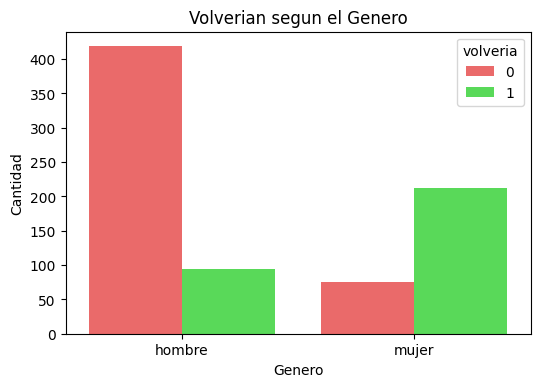

In [19]:
plt.figure(dpi=100)
sns.countplot(data=df, x='genero', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Genero")
plt.title("Volverian segun el Genero")

Como podemos observar, existe una relación muy fuerte entre el genero y las respuestas que dieron sobre si volverian o no, teniendo en los hombres una predeterminación a no volver y en las mujeres lo opuesto.

In [20]:
df.groupby(by='genero').agg({
        "volveria" : porcentajeVolveria
})

,volveria
genero,
hombre,18.323587
mujer,73.958333


Con estos ultimos datos, podemos ver que la tendencia de no regresar de los hombres es mas marcada que la de volver de las mujeres. Aún así, estos valores nos muestran una tendencia muy marcada para cada uno de los generos, lo que nos proporciona una buena variable para iniciar nuestra función de predicción.

### Anásisis de la columna "Amigos"

Aquí nos centraremos en ver si existe alguna influencia con la variable target: "volveria" respecto a la cantidad de amigos.

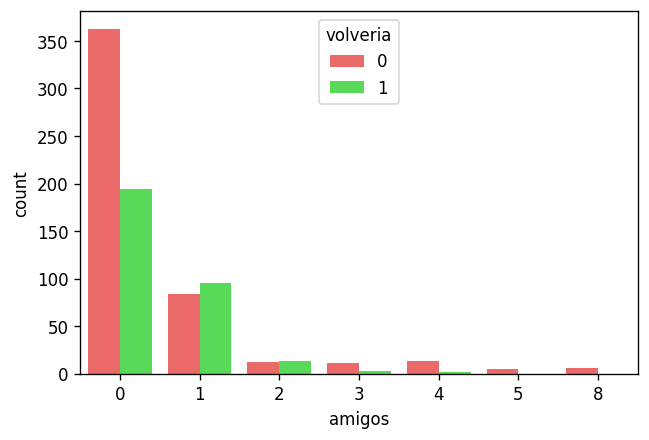

In [21]:
plt.figure(dpi=120)
sns.countplot(data=df, x='amigos', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'})

plt.show()

Podemos observar que la cantidad de personas que **no volveria es importante para cuando la persona va sin amigos**, 
respecto a la cantidad de personas que volverían.

Mientras que para las personas que van con 1 amigo ó más, notamos que no hay diferencias marcadas como para tomar una determinación clara sobre si volveria al cine ó no.

A continuación los porcentajes en valor numérico para cada cantidad de amigos en el df:

In [22]:
volveria_por_sede = df.groupby(by='amigos').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_sede

,volveria
amigos,
0,34.829443
1,53.072626
2,52.000000
3,21.428571
4,13.333333
5,0.000000
8,0.000000


### Análisis de la columna "Parientes"

En este caso haremos un análisis similar teniendo en cuenta también la cantidad de parientes respecto a la cantidad de personas que volverían(1) ó no(0)

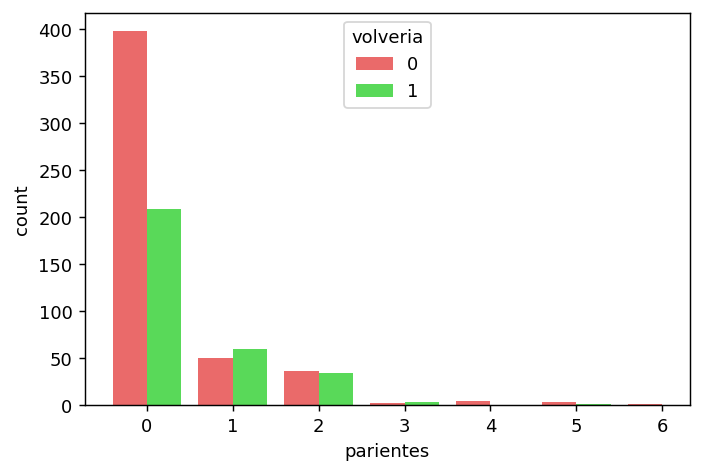

In [23]:
import seaborn as sns

plt.figure(dpi=130)
sns.countplot(data=df, x='parientes', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'})
plt.plot()
plt.show()

Podemos observar que la cantidad de personas que **no volveria es reelevante para cuando la persona va sin parientes**, 
respecto a la cantidad de personas que volverían para esa misma cantidad de parientes.

Mientras que para las personas que van con 1 pariente ó más, notamos que no hay diferencias marcadas como para tomar una determinación clara sobre si volveria al cine ó no.

A continuación una muestra de los porcentajes obtenidos para cada grupo de parientes:

In [24]:
volveria_por_sede = df.groupby(by='parientes').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_sede

,volveria
parientes,
0,34.431631
1,54.545455
2,48.571429
3,60.000000
4,0.000000
5,25.000000
6,0.000000


### ¿Qué pasa cuando la persona concurre al cine acompañado ó no?

Luego de análizar las últimas 2 variables, vemos una tendencia a que la gente tiene una tendencia a no volver al cine en caso de ir sin amigos ó sin parientes, Entonces se nos ocurre la idea de analizar el dataframe construyendo una columna basándonos en si la persona fue acompañada al cine ó no, con el objetivo de ver si tienen la misma tendencia de resultados en el target: `volveria`, respecto a el análisis de amigos y parientes.

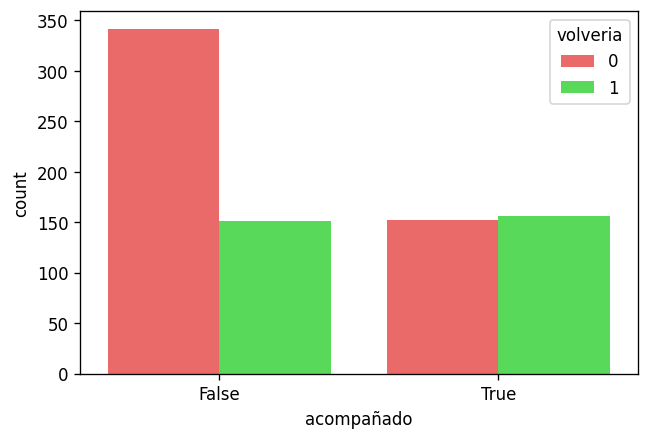

In [25]:
def transformar_acompañado(amigos, parientes):
    return ((amigos > 0) | (parientes > 0))

df['acompañado'] = df.apply(lambda x: transformar_acompañado(x.amigos, x.parientes), axis=1)
plt.figure(dpi=120)
sns.countplot(data=df, x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'}, orient="vertical")
plt.show()

Esto nos da una noción de que el ir acompañado ayuda un poco pero no es un variable que nos sirva de mucho a la hora de decidir si volveria al cine.
Mientras que el hecho de ir sólo, hace que dificilmente vuelva y puede ser reelevante para futuros análisis y el armado del baseline.

Acontinuación se muestran los porcentajes obtenidos para esta nueva columna en el data frame:

In [26]:
volveria_por_sede = df.groupby(by='acompañado').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_sede

,volveria
acompañado,
False,30.628803
True,50.649351


### Análisis de la columna "nombre_sede"

para este análisis usamos un gráfico de barras con el objetivo de cuantificar que cantidad de personas vuelve ó no al cine según la sede. para ello agrupo el data frame por sedes y luego ploteo con el target.

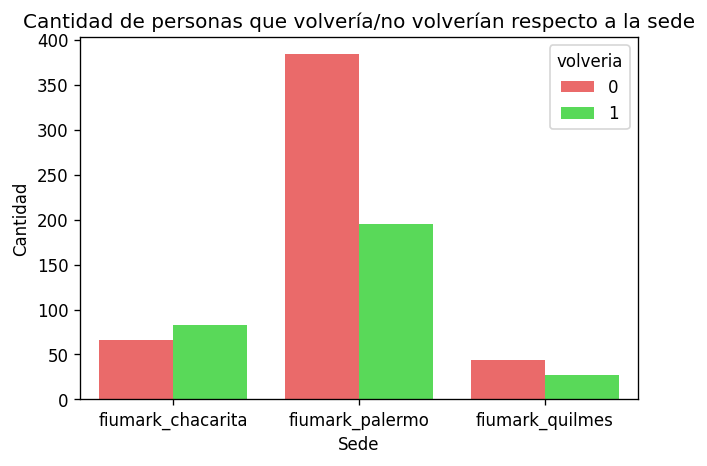

In [27]:
plt.figure(dpi=120)
sns.countplot(data=df, x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'}, order=["fiumark_chacarita","fiumark_palermo","fiumark_quilmes"])
plt.title("Cantidad de personas que volvería/no volverían respecto a la sede")
plt.ylabel("Cantidad")
plt.xlabel("Sede")
plt.show()



Aquí podemos inferir que para la sede palermo la mayor parte de personas encuestadas no volvería, y en una gran cantidad respecto al total de usuarios encuestados(~800). Lo que nos da un pie a un posible futuro análisis junto a otras variables.

A continuación muestro los porcentajes de el target volveria en referencia a cada sede:

In [28]:
volveria_por_sede = df.groupby(by='nombre_sede').agg({
        "volveria" : porcentajeVolveria,       
})
volveria_por_sede

,volveria
nombre_sede,
fiumark_chacarita,55.704698
fiumark_palermo,33.678756
fiumark_quilmes,38.028169


### Análisis de la columna "tipo_de_sala"

Nuevamente analizamos la variable **tipo_de_sala**, discreta, de solo 3 tipos de sala: **normal, 3d y 4d**. ploteamos las cantidad y porcentajes en función de la variable target y obtuvimos los siguentes valores. 

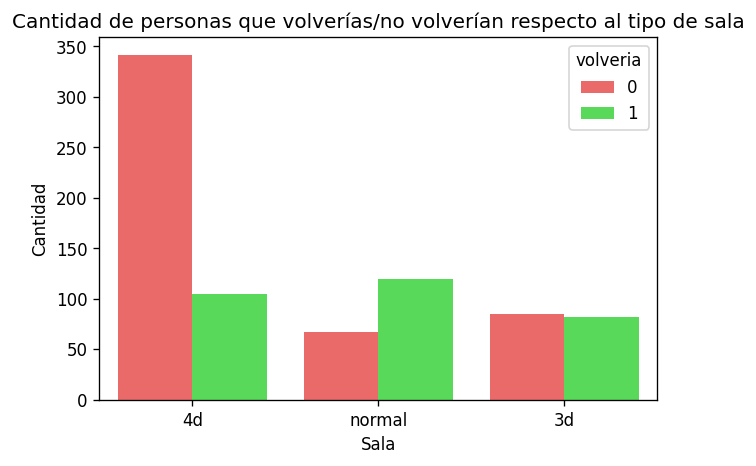

In [29]:
plt.figure(dpi=120)
sns.countplot(data=df, x='tipo_de_sala', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'} )
plt.title("Cantidad de personas que volverías/no volverían respecto al tipo de sala")
plt.ylabel("Cantidad")
plt.xlabel("Sala")
plt.show()

## Analisis de la columna "Precio Ticket"

Como previamente hicimos, analizaremos a grande razgos la variable en un principio para ver si existe algun categoría de precio que debamos analizar en particular.

Text(0.5, 1.0, 'Volverian segun el precio del ticket')

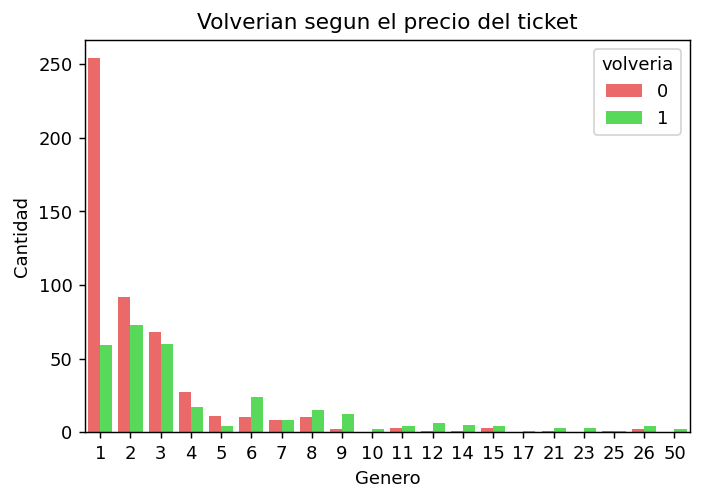

In [30]:
plt.figure(dpi=130)
sns.countplot(data=df, x='precio_ticket', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Genero")
plt.title("Volverian segun el precio del ticket")

Como podemos observar, para los que su precio de ticket fue categorizado como `1`, las respuestas negativas son muy altas en comparación con las respuestas positivas. Esto nos inclina a analizar en parte para todos aquellos que tuvieron esa categoria, en comparación con los que tuvieron otra categoria de precio. Para esto, vamos a generar una nueva categoría que se llamara precio_1 y tendra un True o False si pertenece a dicha categoria.

In [31]:
def categorizarPrecio(precio):
    return precio == 1


df['es_precio_ticket_1'] = df.precio_ticket.apply(categorizarPrecio)
df

,tipo_de_sala,nombre,genero,edad,amigos,parientes,id_ticket,precio_ticket,nombre_sede,volveria,edad_categorizada,acompañado,es_precio_ticket_1
id_usuario,,,,,,,,,,,,,
117,4d,Señor Camilo Pedro,hombre,73.5,0,0,59258;,1,fiumark_quilmes,0,7.0,False,True
658,4d,Señora Raquel Angelica,mujer,35.0,1,1,586:6;,2,fiumark_quilmes,0,4.0,True,False
794,normal,Señor Antonio Federico,hombre,NaN,0,0,"RE""39822",3,fiumark_chacarita,0,NaN,False,False
455,4d,Señor Osvaldo Aureliano,hombre,NaN,0,0,"C17""4:39",1,fiumark_palermo,0,NaN,False,True
173,4d,Señorita Rita Eudosia,mujer,4.0,1,1,569964,2,fiumark_palermo,1,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,normal,Señor Bernardo Melesio,hombre,37.0,0,0,3359;6,3,fiumark_palermo,1,4.0,False,False
636,3d,Señorita Lidia Catalina,mujer,31.0,0,0,45988:,2,fiumark_palermo,1,3.0,False,False
848,4d,Señor Arturo Antenor,hombre,38.0,0,0,56;435,1,fiumark_chacarita,0,4.0,False,True


Text(0.5, 1.0, 'Volverian segun el precio del ticket')

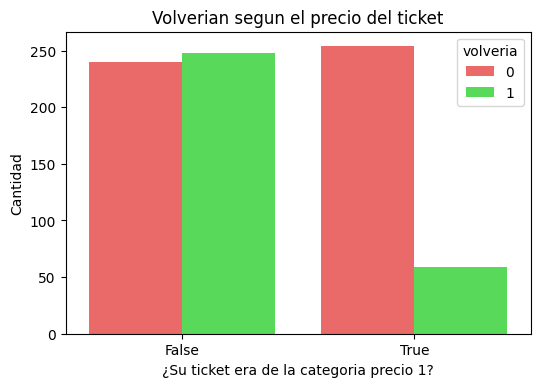

In [32]:
plt.figure(dpi=100)
sns.countplot(data=df, x='es_precio_ticket_1', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("¿Su ticket era de la categoria precio 1?")
plt.title("Volverian segun el precio del ticket")

Como ya vimos, para aquellos que fueron categorizados que abonaron el precio ticket `1` tienen una gran tendencia en la respuesta a no volver. Sin embargo, agrupando todas las otras categorias, vemos que es bastante similar los valores, con una leve inclinación a volver.

In [33]:
df.groupby(by='es_precio_ticket_1').agg({"volveria" : porcentajeVolveria})

,volveria
es_precio_ticket_1,
False,50.819672
True,18.849840


# Conclusión de los Análisis de las Variables Individuales

De las variables anteriores, hemos visto que la mas marcada diferencia entre volveria o no y entre sus distintas sub-categorias fue la variable genero. Es por eso que vamos a tomar a esta primera variable para generar nuestra primera función de predicción.

# Función de Predicción (Accuracy)

La función `porcentualAcertado` nos permitira pasarle dos listados representando en el mismo orden los valores de si volvería o no retornando un valor porcentual de acierto.

In [34]:
def porcentualAcertado(a,b):
    cantidad_acertada = 0
    total_usuarios = len(a)
    for i in range(total_usuarios):
        if(a[i] == b[i]):
            cantidad_acertada += 1
    return cantidad_acertada / total_usuarios

Luego definiremos la función `baseline` la cual tiene por objetivo recibir un data frame y asi retornar el listado ordenado de si cumple o no para cada respuesta del formulario. Para esto utilizara la `funcionPrediccion` definida que determinara por fila si debe volver o no, retornando 0 para no volveria y 1 para volveria.

In [35]:
def baseline(dataFrame):
    resultado = []
    for i, fila in dataFrame.iterrows():
        resultado.append(funcionPrediccion(fila))
    return resultado

Y por ultimo, vamos a definir la función `accuracy`, que nos retornara el porcentaje de aciertos que posee una función determinada para un data frame.

In [36]:
def accuracy(dataFrame):
    aciertos = porcentualAcertado(baseline(dataFrame.drop(columns=['volveria'],inplace=False)), dataFrame['volveria'].to_list())
    return round(aciertos * 100, 2)

# Generación de la función de predicción

Primeramente vamos a tratar de analizar una función muy basica asumiendo que todos volverian

In [37]:
def funcionPrediccion(fila):
     return 1
accuracy(df)

38.33

Como podemos observar, una función asi solo nos da un 38,33% de acierto. Este numero tampoco es al azar, ya que coincide con el porcentaje de volverian que habia en nuestro data frame. Para mejorar el valor predecido, podemos utilizar el negado de esta función asumiendo que todos no volverian, donde obtendremos el resultado complemento

In [38]:
def funcionPrediccion(fila):
     return 0
accuracy(df)

61.67

De los analisis anteriores, esta vez vamos a generar una función de predicción utilizando la variable con mayor polarizacion que observamos que fue la variable Genero. En este caso, si nos encontramos con una mujer asumiremos que volvera, y en cambio para los hombres, el resultado sera el opuesto.

In [39]:
def funcionPrediccion(fila):
     return 1 if (fila['genero'] == 'mujer') else 0
accuracy(df)

78.9

Como podemos observar, ya solo haber realizado un filtrado por dicha variable, generamos una función de predicción capaz de acertar en un 78,9% en relación con la información original que teniamos, el cual es un mejor valor que asumir que ninguno volvia.

Realizaremos otras funciones de predición en base a los analisis superiores de cada variable individual como para revisar si existe alguna otra variable que nos presente un mejor valor.

In [40]:
def funcionPrediccion(fila):
     return 1 if (fila['es_precio_ticket_1'] == False) else 0
accuracy(df)

62.67

In [41]:
def funcionPrediccion(fila):
     return 1 if (fila['tipo_de_sala'] == '4D') else 0
accuracy(df)

61.67

In [42]:
def funcionPrediccion(fila):
     return 1 if (fila['acompañado']) else 0
accuracy(df)

62.17

In [43]:
def funcionPrediccion(fila):
     return 1 if (fila['nombre_sede'] == 'fiumark_chacarita') else 0
accuracy(df)

63.8

In [44]:
def funcionPrediccion(fila):
     return 1 if (fila['tipo_de_sala'] == 'normal') else 0
accuracy(df)

68.29

Como pudimos observar de estos analisis, el que nos genero una mayor porcentaje de aciertos fue cuando nuestra funcion de predicción se baso simplemente en la variable genero.

## Correlación entre variables

A continuación vamos a tratar de analizar si existen algunas relaciones entre las distintas variables que nos permita mejorar nuestra función de predicción. Para eso, trataremos de encontrar algun comportamiento que no se relacione con lo que ya fuimos observando para cada una de las mismas.

### Genero en relación con el Precio del Ticket

Anteriormente observamos que las mujeres en su gran mayoría respondian que volverian mientras que los hombres lo opuesto. Por otro lado, pudimos observar que en cuanto al precio pagado por el ticket, aquellos que su ticket tuvo el valor categorizado como `1`, no solo son el grupo mayoritario, sino que ademas, la gran mayoría de estos respondio que no volveria.

En los analisis siguientes trataremos de encontrar si existe o no una relación entre las variables. Para ello, lo que haremos es separar por genero y segun si su precio de ticket corresponde a la categoría uno o no.

Text(0.5, 1.0, '¿Volverian por Genero que tuvieron el precio de ticket 1?')

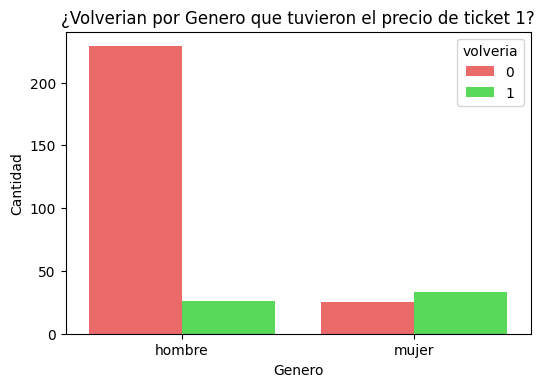

In [45]:
plt.figure(dpi=100)
sns.countplot(data=df[df.es_precio_ticket_1], x='genero', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Genero")
plt.title("¿Volverian por Genero que tuvieron el precio de ticket 1?")

Text(0.5, 1.0, '¿Volverian por Genero que tuvieron otro precio de ticket que no fue el 1?')

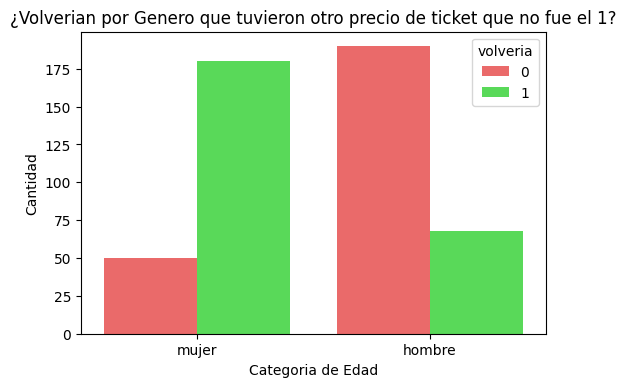

In [46]:
plt.figure(dpi=100)
sns.countplot(data=df[df.es_precio_ticket_1 == False], x='genero', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Categoria de Edad")
plt.title("¿Volverian por Genero que tuvieron otro precio de ticket que no fue el 1?")

De estos graficos podemos observar que en todos los escenarios, las mujeres volverian mientras que los hombres no, independientemente de la si fueron categorizados en el precio que pagaron con el valor `1`. Es importante igual destacar, que el valor en las mujeres que volverian pagando dicha tarifa es mayor pero muy similar a las que no volverian. Dado este escenario que no altera lo que esperabamos, dejaremos el analizar la posibilidad de la influencia en el tipo de precio para mas adelante.

### Genero en relación con el tipo de sala

Esta vez vamos a concentrarnos en si para algun tipo de sala, uno de los generos se comporta distinto a lo esperado, es decir, que las mujeres vuelvan en mayoria y que los hombres no lo hagan.

Text(0.5, 1.0, '¿Cual fue la respuesta para los hombres segun el tipo de sala?')

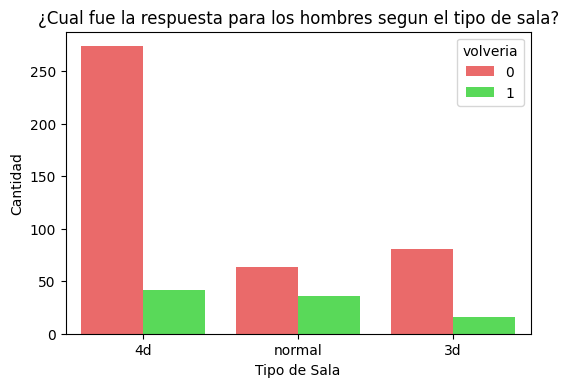

In [47]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'hombre' ], x='tipo_de_sala', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para los hombres segun el tipo de sala?")

Text(0.5, 1.0, '¿Cual fue la respuesta para las mujeres segun el tipo de sala?')

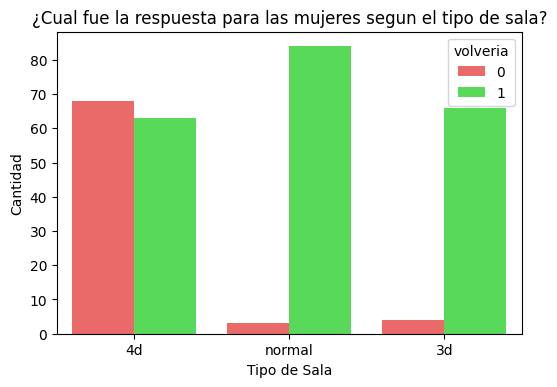

In [48]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'mujer'], x='tipo_de_sala', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres segun el tipo de sala?")

En el primer grafico no observamos ninguna diferencia con lo que veniamos viendo del analisis de cada variable, es decir, los hombres no volverian independientemente del tipo de sala. Sin embargo, en el segundo grafico encontramos un esceario particular. Las mujeres para las salas 4D en su mayoría responden que no volverian. Esto nos da un inidicio para mejorar nuestra función de predicción ya que deberemos considerar este escenario particular para las mujeres.

In [49]:
def funcionPrediccion(fila):
    if (fila['genero'] == 'mujer') & (fila['tipo_de_sala'] != '4d'):
        return 1
    return 0
accuracy(df)

79.53

Esto nos permitio aumentar de 78,9% a un 79,53% de aciertos.

### Genero en relación con la sede

En este caso, vamos a evaluar si existe una relacion entre dichas variables.

Text(0.5, 1.0, '¿Cual fue la respuesta para los hombres segun la sede?')

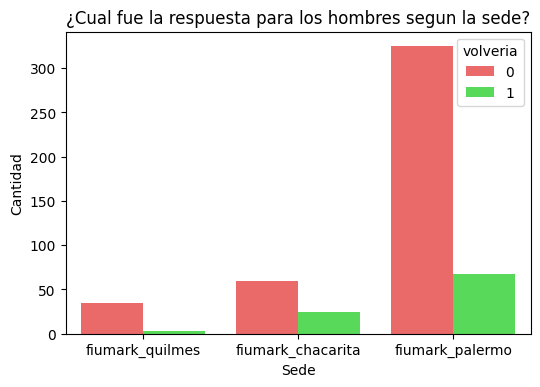

In [50]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'hombre' ], x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Sede")
plt.title("¿Cual fue la respuesta para los hombres segun la sede?")

Text(0.5, 1.0, '¿Cual fue la respuesta para las mujeres segun la sede?')

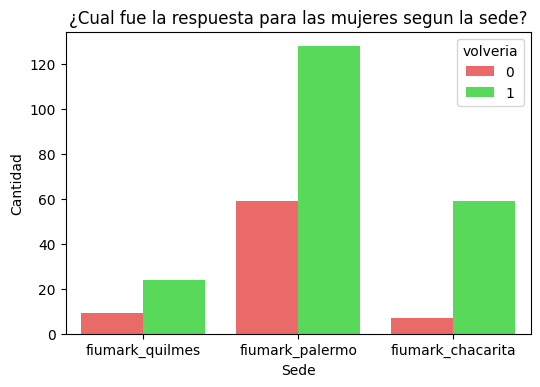

In [51]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'mujer' ], x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Sede")
plt.title("¿Cual fue la respuesta para las mujeres segun la sede?")

Para estos graficos, no encontramos nada distinto a lo que veniamos viendo. En todas las sedes las mujeres prefieren volver y los hombres no.

### Genero en relación con la edad

Para este escenario vamos a ver como se relaciona el genero con la edad utilizando inicialmente nuestra variable de categoría de edad.

Text(0.5, 1.0, 'Cantidades segun la categoria de edad')

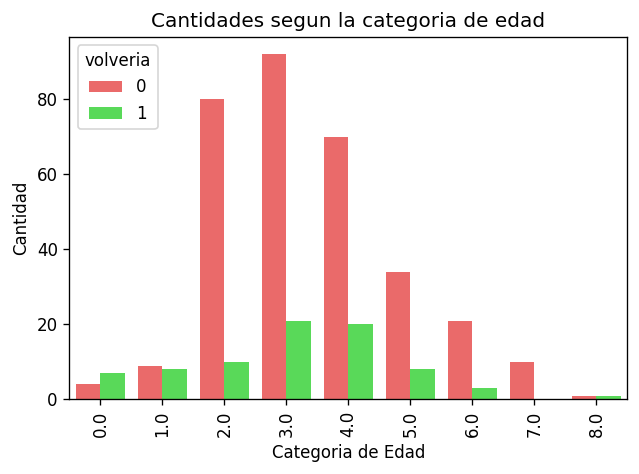

In [52]:
plt.figure(dpi=120)
data=df[df['genero'] == 'hombre' ]
sns.countplot(data=data, x='edad_categorizada', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xticks(rotation='vertical')
plt.xlabel("Categoria de Edad")
plt.title("Cantidades segun la categoria de edad")

Text(0.5, 1.0, 'Cantidades segun la categoria de edad')

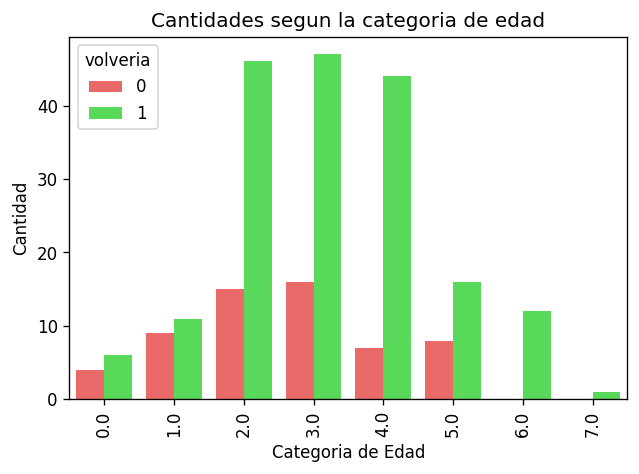

In [53]:
plt.figure(dpi=120)
data=df[df['genero'] == 'mujer' ]
sns.countplot(data=data, x='edad_categorizada', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xticks(rotation='vertical')
plt.xlabel("Categoria de Edad")
plt.title("Cantidades segun la categoria de edad")

Como podemos observar encontramos un escenario particular que para la categoría de 0 para los hombres, es decir, hombres entre 0 y 10 años, su tendencia es la de volver. Esto es contrario a lo que esperabamos y deberiamos analizar mas dicha información. En este caso, lo que debemos hacer es encontrar el limite, para los cuales los hombres prefieren volver.

Text(0.5, 1.0, 'Cantidades segun la categoria de edad')

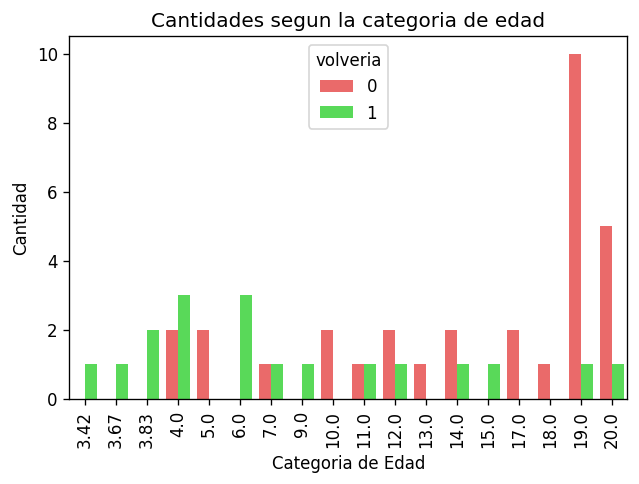

In [54]:
plt.figure(dpi=120)
data=df[(df['genero'] == 'hombre') & (df['edad'] <= 20.0 ) ]
sns.countplot(data=data, x='edad', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xticks(rotation='vertical')
plt.xlabel("Categoria de Edad")
plt.title("Cantidades segun la categoria de edad")

A continuación, nos interesa encontrar el punto de corte, para el cual existen mayores respuestas positivas que negativas.

In [55]:
values = {}
data=df[df['genero'] == 'hombre' ]
for x in range(20,4,-1):
    data=data[data['edad'] <= x ]
    data_volverian = data[data['volveria'] == 1 ]
    y = data_volverian.value_counts().sum() / data.value_counts().sum() * 100
    values[x] = y
values

{20: 36.734693877551024,
 19: 39.53488372093023,
 18: 50.0,
 17: 51.61290322580645,
 16: 55.172413793103445,
 15: 55.172413793103445,
 14: 53.57142857142857,
 13: 56.00000000000001,
 12: 58.333333333333336,
 11: 61.904761904761905,
 10: 63.1578947368421,
 9: 70.58823529411765,
 8: 68.75,
 7: 68.75,
 6: 71.42857142857143,
 5: 63.63636363636363}

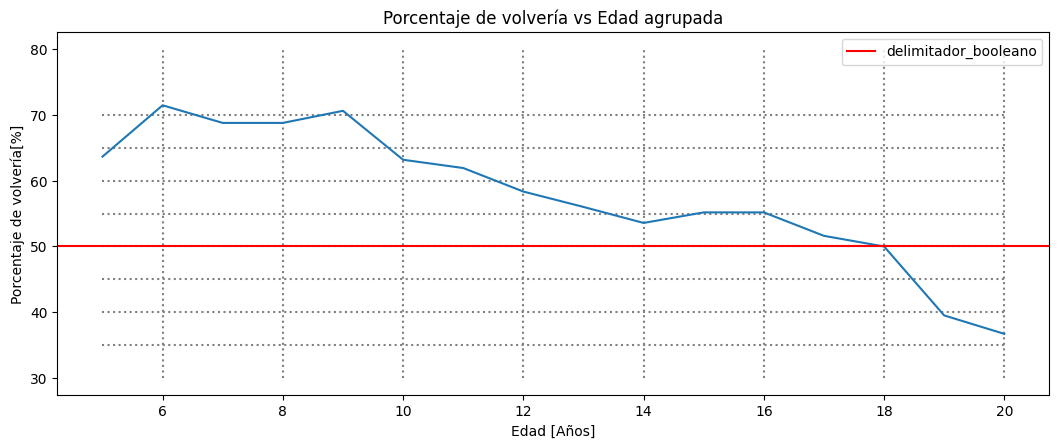

In [129]:
lists = sorted(values.items())
x, y = zip(*lists)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[6.4 * 2 , 4.8], dpi=100)
axes.plot(x, y)
axes.set_title('Porcentaje de volvería vs Edad agrupada')
axes.set_xlabel('Edad [Años]')
axes.set_ylabel('Porcentaje de volvería[%]')

delimitador_bool = plt.axhline(y=50, color='r', linestyle='-', label='delimitador_booleano')
plt.hlines(xmin=5, xmax=20, y=[35, 40, 45, 50, 55, 60, 65, 70], color='gray', linestyle='dotted')
plt.vlines(x=[6, 8, 10, 12, 14, 16, 18, 20], ymin=30, ymax=80, color='gray', linestyle='dotted')
plt.legend(handles=[delimitador_bool])


plt.show()

Como se puede observar, el punto de corte de acumulación es de 18 años. Esto quiere decir, que para todo hombre de que tenga menos de 18 años, tendra una tendencia positiva para volver

In [57]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

79.65

En este caso, mejoramos muy poco nuestra predicción pero pudimos incoporar una mejora determinando que los hombres menores a 18 prefieren volver.

### Genero en relación con si vino acompañado

En este caso, vamos a evaluar si existe una relacion entre el genero y si vino acompañado a la hora de responder sobre si volverian.

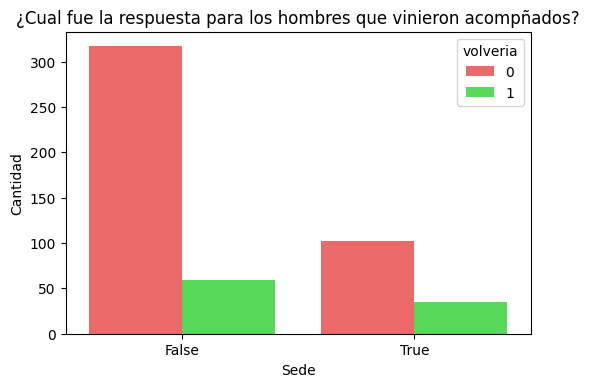

In [58]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'hombre' ], x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Sede")
plt.title("¿Cual fue la respuesta para los hombres que vinieron acompñados?")
plt.show()

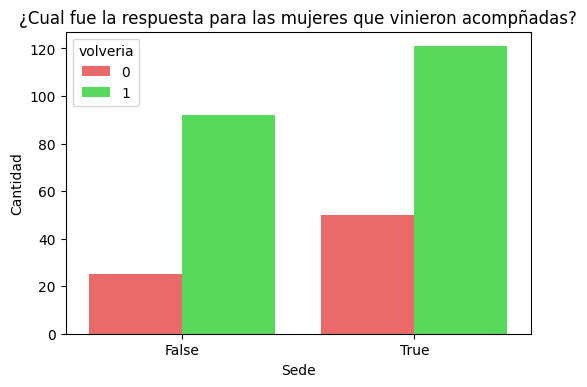

In [59]:
plt.figure(dpi=100)
sns.countplot(data=df[df['genero'] == 'mujer' ], x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Sede")
plt.title("¿Cual fue la respuesta para las mujeres que vinieron acompñadas?")
plt.show()

Nuevamente, en este analisis no encontramos ningun resultado inesperado. Las mujeres prefieren volver y los hombres no.

## Correlación entre tres variables

En esta zona vamos a tratar de encontrar relaciones entre 3 variables. Dado que de la parte anterior aprendimos que las mujeres vuelven salvo para las salas 4D y los hombres no vuelven salvo aquellos que tienen menos de 18 años, estas dos variables las usaremos de base y buscaremos si una tercer variable puede afectar dichos resultados y darnos un indicio de como mejorar aun mas nuestra funcion de predicción.

### Relaciones con el precio del ticket

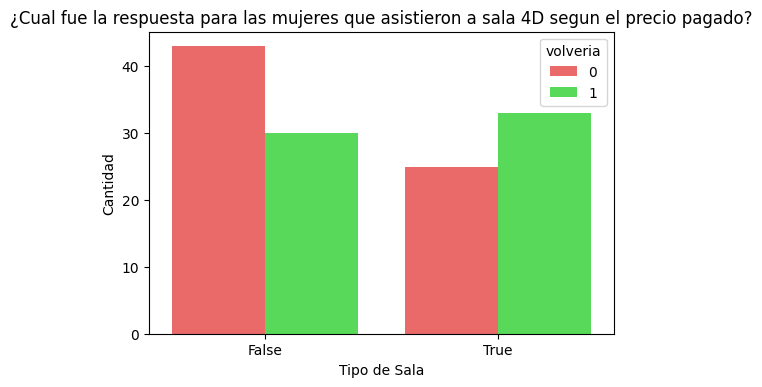

In [60]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] == '4d')]
sns.countplot(data=data, x='es_precio_ticket_1', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que asistieron a sala 4D segun el precio pagado?")
plt.show()

De este ultimo grafico, vemos que para las mujeres si pago el tipo de ticket `1`, indistintamente de haber asistido a la sala 4D, si deciden volver en su gran mayoria. Esto nos sirve para mejorar aun mas nuestra función de predicción

In [61]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['es_precio_ticket_1'])):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

80.65

Esto ya nos logro elevar nuestro valor de acierto a un 80,65%, y es el valor mas alto que hemos conseguido hasta el momento. Ahora nos falta por analizar si para las mujeres que no fueron a la sala 4D si el precio de ticket influencio.

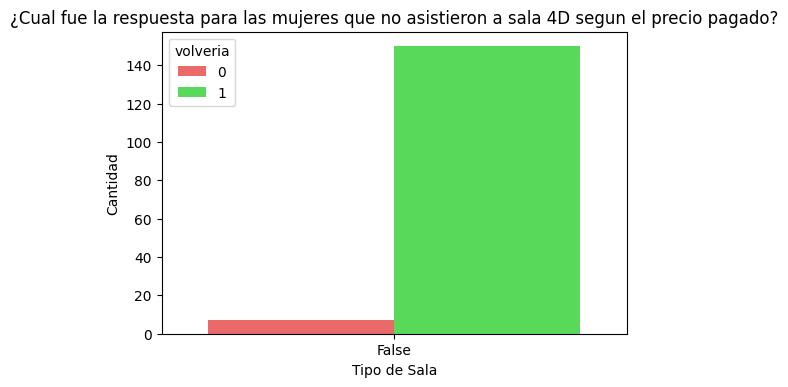

In [62]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] != '4d')]
sns.countplot(data=data, x='es_precio_ticket_1', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que no asistieron a sala 4D segun el precio pagado?")
plt.show()

En este caso, no obtuvimos información nueva.

Para continuar con los analisis, ahora vamos a trabajar con los hombres, y esta vez separando para los menores y para los mayores de 18 años.

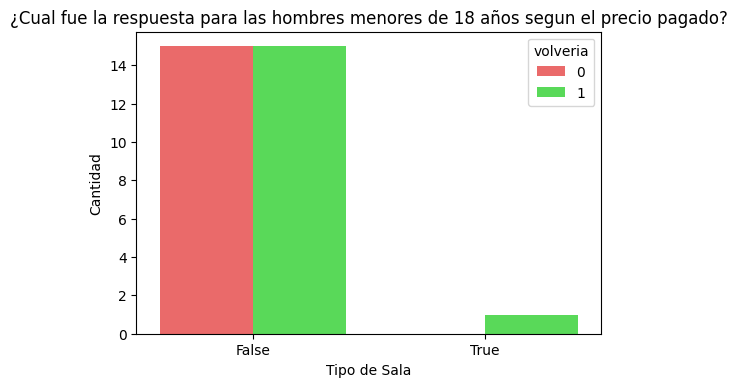

In [63]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] < 18)]
sns.countplot(data=data, x='es_precio_ticket_1', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres menores de 18 años segun el precio pagado?")
plt.show()

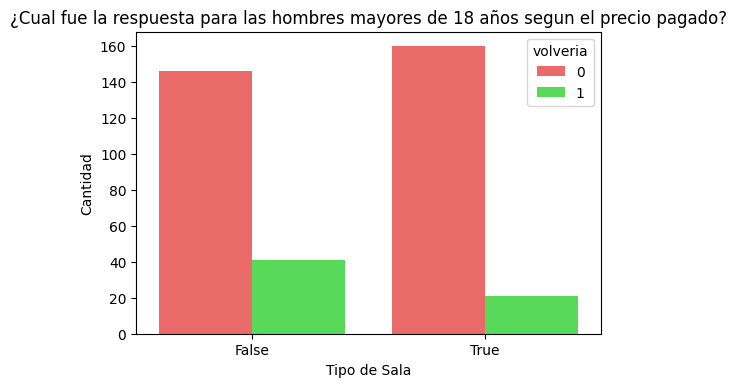

In [64]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] >= 18)]
sns.countplot(data=data, x='es_precio_ticket_1', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres mayores de 18 años segun el precio pagado?")
plt.show()

Para estos dos graficos, no obtuvimos nueva información que nos sirva para mejorar nuestra función de predicción. Si cabe destacar que el resultado de hombres menores de 18 años y que no pagaron la tarfia del ticket 1 dio un valor igualado, pero esto no nos genera una tendencia inversa a lo que habiamos visto.

### Relaciones con el tipo de sala

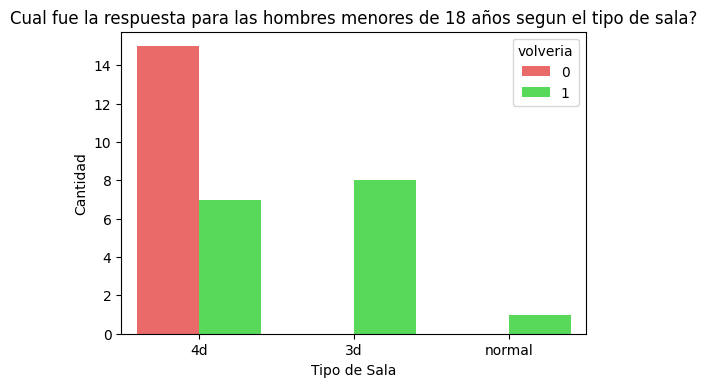

In [65]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] < 18)]
sns.countplot(data=data, x='tipo_de_sala', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("Cual fue la respuesta para las hombres menores de 18 años segun el tipo de sala?")
plt.show()

De este grafico observamos que los hombres menores de 18 años para las salas 4d prefieren no volver mientras que para las otras si. Esto se comporta distinto a lo esperado y nos sirve para nuevamente mejorar la función de predicción.

In [66]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['es_precio_ticket_1'])):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['tipo_de_sala'] == '4d')): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

81.65

Con este ultimo cambio, hemos llegado nuevamente al valor mas alto de predicción hasta el momento logrando un 81,65% de certeza utilizando los mismos datos de entrada.

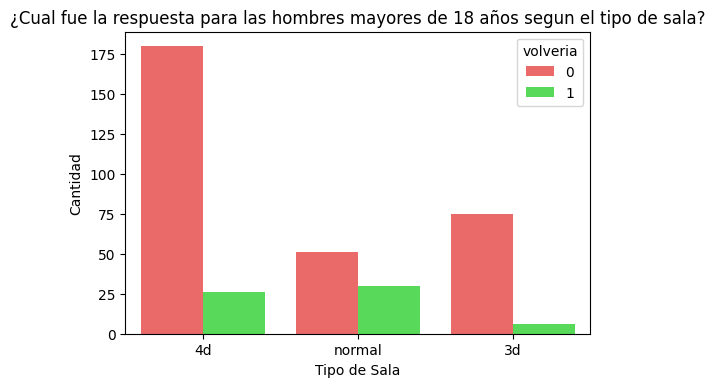

In [67]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] >= 18)]
sns.countplot(data=data, x='tipo_de_sala', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres mayores de 18 años segun el tipo de sala?")
plt.show()

En este ultimo grafico, no encontramos ninguna diferencia con lo esperado de que los hombres mayores a 18 años deciden no volver.

Como ya habiamos analizado y encontrado una relacion entre las mujeres y el tipo de sala que nos sirvio para mejorar nuestro algortimo, no debemos volver a realziar dicha comparación.

### Relaciones con acompañado

En este escenario analizaremos las relaciones entre mujeres, si asistieron o no a una sala 4d y si asistieron acompados, y entre los hombres, su edad en relacion a los 18 y si asistieron acompañdos.

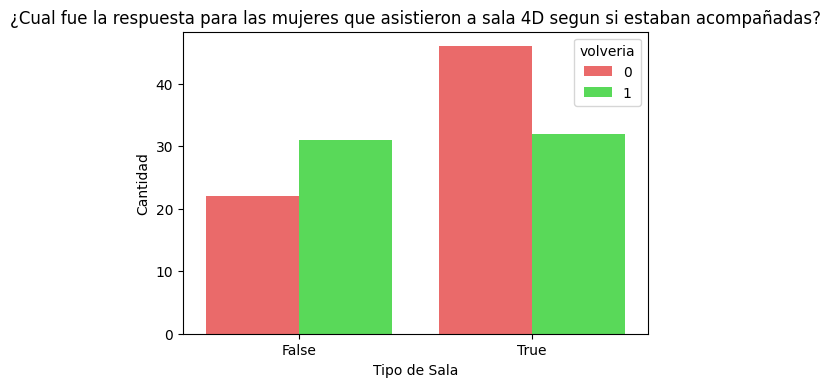

In [68]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] == '4d')]
sns.countplot(data=data, x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que asistieron a sala 4D segun si estaban acompañadas?")
plt.show()

Esta función nos muestra que las mujeres que no fueron acompañadas y asistieron a una sala 4D, tienen una preferencia por volver. Realizaremos el calculo de esta nueva funcion de predicción y compararemos si es mejor analizar por el acompañamiento o por si abonaron el tipo de ticket 1.

In [69]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['acompañado'] == False)):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['tipo_de_sala'] == '4d')): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

81.77

Dado que este resultado es el mas alto obtenido hasta el momento, encontramos que es mejor realizar esta comparación como tercer variable correlacionada para las mujeres que asistieron a salas 4D. Esto se da debido al volumen de casos de diferencia que en esta combinación fue mas alto que para la el precio de ticket 1.

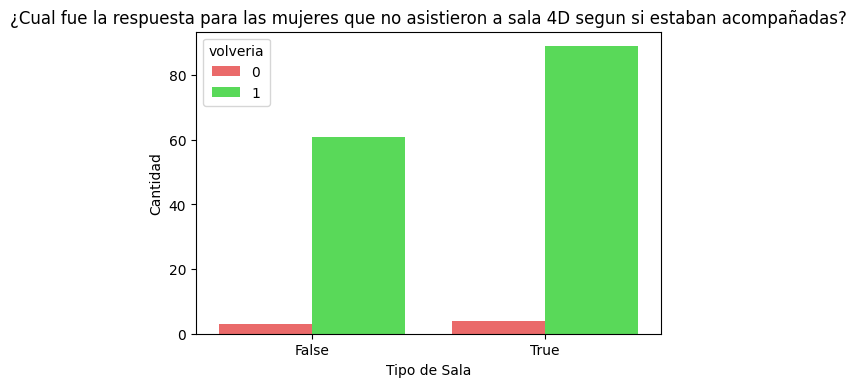

In [70]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] != '4d')]
sns.countplot(data=data, x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que no asistieron a sala 4D segun si estaban acompañadas?")
plt.show()

Este ultimo grafico no nos dio ninguna nueva información util.

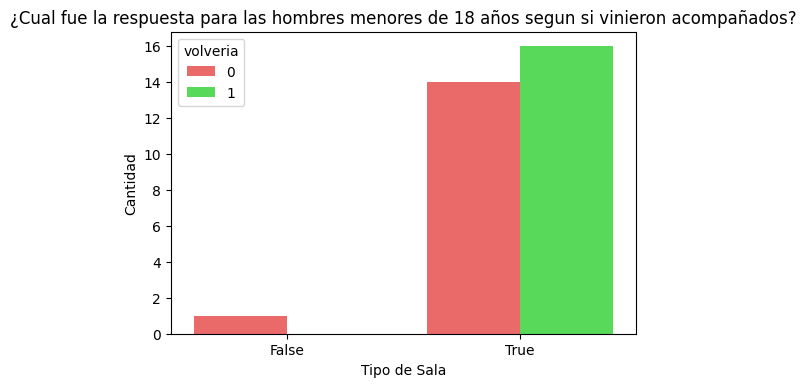

In [71]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] < 18)]
sns.countplot(data=data, x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres menores de 18 años segun si vinieron acompañados?")
plt.show()

Si bien este grafico nos muestra que si no vino acompañado hay una preferencia negativa, el volumen que vemos es muy chico. Revisaremos si mejora la funcion de predicción o si en realidad la empeora.

In [72]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['acompañado'] == False)):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['acompañado'] == False)): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

80.9

Como vemos, esto genero un peor resultado por lo que procedemos a descartar esta información.

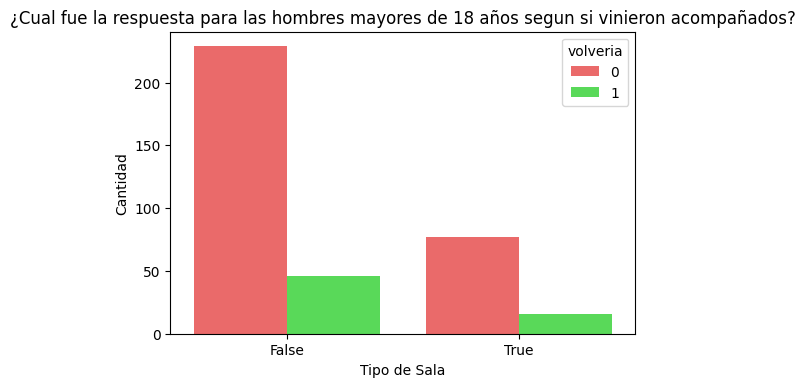

In [73]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] >= 18)]
sns.countplot(data=data, x='acompañado', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres mayores de 18 años segun si vinieron acompañados?")
plt.show()

En este escenario, nuevamente, no volvimos a encontrar información util, ya que conociamos que los hombres mayores de 18 tenian tendencia a no volver.

### Relaciones con la sede

En este escenario analizaremos las relaciones entre mujeres, si asistieron o no a una sala 4d y la sede a la cual asistieron, y entre los hombres, su edad en relacion a los 18 y la sede donde asisitieron.

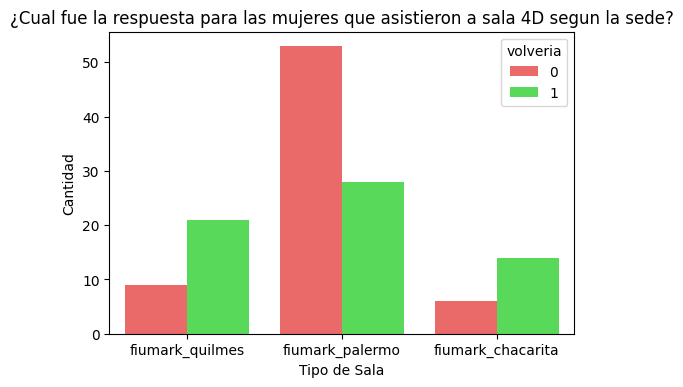

In [74]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] == '4d')]
sns.countplot(data=data, x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que asistieron a sala 4D segun la sede?")
plt.show()

Este resultado es interesante por dos motivos. En primer lugar, en dos sedes las mujeres informan que volverian por fuera de haber asistido a una sala 4d. Adicionalmente, los volumenes de diferencia parecen ser grandes para los volumenes que venimos manejando entre 3 variables, lo que nos da un indicio de tal vez haber dado con una variable que nos permita mejorar aun mas nuestro modelo de predicción.

In [75]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['nombre_sede'] != 'fiumark_palermo')):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['tipo_de_sala'] == '4d')): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

83.15

Efectivamente, esto nos llevo al mejor resultado hasta el momento, obteniendo un 83,15% de certeza en nuestra predicción.

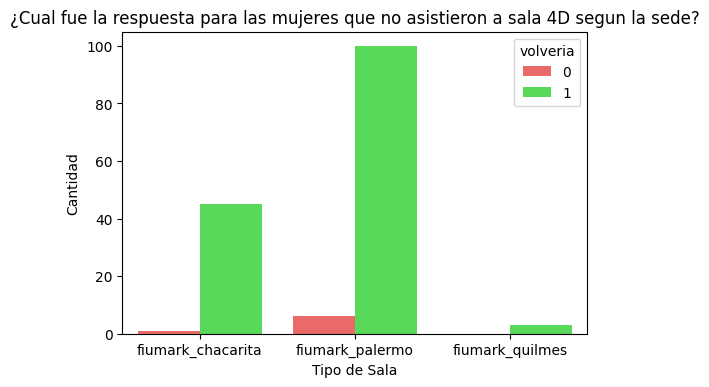

In [76]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'mujer') & (df['tipo_de_sala'] != '4d')]
sns.countplot(data=data, x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las mujeres que no asistieron a sala 4D segun la sede?")
plt.show()

En este caso, no encontramos nueva información. Pasamos a hacer el analisis para los hombres.

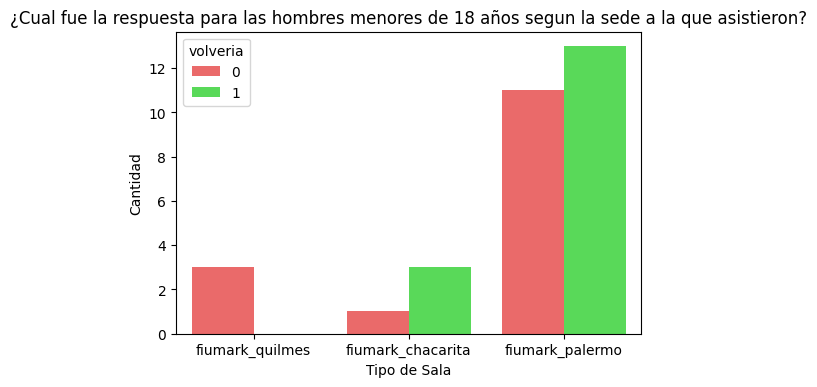

In [77]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] < 18)]
sns.countplot(data=data, x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres menores de 18 años segun la sede a la que asistieron?")
plt.show()

In [78]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['nombre_sede'] != 'fiumark_palermo')):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['nombre_sede'] == 'fiumark_quilmes')): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

82.52

Si bien encontramos nuevamente un valor distinto, el valor de acierto desendio de nuestro mejor resultado. Por lo que descartaremos esta información y mantendremos la anterior función de predicción.

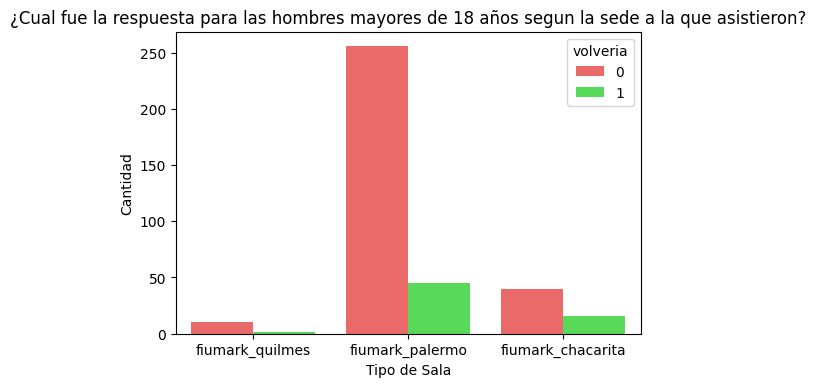

In [79]:
plt.figure(dpi=100)
data = df[ (df['genero'] == 'hombre') & (df['edad'] >= 18)]
sns.countplot(data=data, x='nombre_sede', hue='volveria', palette={0: '#FF5555', 1: '#44EE44'},orient="vertical")
plt.ylabel("Cantidad")
plt.xlabel("Tipo de Sala")
plt.title("¿Cual fue la respuesta para las hombres mayores de 18 años segun la sede a la que asistieron?")
plt.show()

Nuevamente, no encontramos información que nos mostrara un resultado imprevisto.

# Conclusión

Si bien el analisis puede continuar tratando de esta vez correlacionar 4 variables, decidimos no continuar debido a que superamos el valor solicitado por el cliente en cuanto al acierto minimo y debido a la complejidad extra de seguir correlacionado variables.

Cabe destacar que por fuera de los datos, la correlación que se dio para las mujeres, nos muestra una posibilidad de un indicio de que la sala 4D de la sede de Fiumark Palermo no se encuentra en buenas condiciones lo que motiva a sus clientes a no querer volver a asistir. Esto tambien podriamos haberlo visto en los hombres ya que en su gran mayoria, los menores de 18 años si respondian que volverian, pero para los que asistieron a una sala 4D dicen que no. Esto nos abre las puertas para un proximo analisis donde quedaria observar si la sede palermo es la sede por la cual los menores de 18 años hombres decian que no volverian y que a su vez habian visto Frozen 3 en una sala 4D.

Por otro lado, como bien encontramos en nuestra variable principal, la tematica de Frozen 3 nos da a entender que existe una fuerte tendencia por las mujeres a querer volver para ver Frozen 4, mientras que para los hombres no, y esto puede estar mas asociado con el genero de la pelicula que con las instalaciones del lugar.

Como anteriormente mostramos, la función de predicción que mejor certeza nos genero es la siguiente:

In [80]:
def funcionPrediccion(fila):
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d') & (fila['nombre_sede'] != 'fiumark_palermo')):
        return 1
    if ((fila['genero'] == 'mujer') & (fila['tipo_de_sala'] == '4d')):
        return 0
    if(fila['genero'] == 'mujer'):
        return 1
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) & (fila['tipo_de_sala'] == '4d')): 
        return 0
    if ((fila['genero'] == 'hombre') & (fila['edad'] < 18) ):
        return 1
    return 0
accuracy(df)

83.15